In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from model.rooms_problem import RoomsProblem
from model.rooms_agents import IndependentClusterAgent, JointClusteringAgent, FlatAgent

from tqdm import tqdm_notebook as tqdm

In [2]:
import numpy as np

def make_rooms(n_repeats = 3, n_mappings = 3, grid_world_size=(6, 6)):

    n_total_rooms = n_mappings * n_repeats
    sucessor_function = {r: {"A": r+1, "B": 0, "C": 0} for r in range(n_total_rooms-1)}
    sucessor_function[n_total_rooms-1] = {"A": None, "B": 0, "C": 0}

    reward_function = {r: {"A": 1, "B": 0, "C": 0} for r in range(n_total_rooms)}

    mappings = {
        0: {0: u'left', 1: u'up', 2: u'down', 3: u'right'},
        1: {4: u'up', 5: u'left', 6: u'right', 7: u'down'},
        2: {1: u'left', 0: u'up', 3: u'right', 2: u'down'},
        3: {5: u'up', 4: u'left', 7: u'down', 6: u'right'},
    }

    room_mappings = {n+(c*n_repeats): mappings[c] for c in range(n_mappings) for n in range(n_repeats)}

    # make it easy, have the door and start locations be the same for each room
    start_location = {r: (0,0) for r in range(n_total_rooms)}

    # make it easy, each door is in the same spot
    door_locations = {r: {
            'A':(grid_world_size[0]-1, grid_world_size[1]-1), 
            'B':(grid_world_size[0]-1, 0), 
            'C':(0, grid_world_size[1]-1)} 
                      for r in range(n_total_rooms)}

    rooms_args = list([room_mappings, sucessor_function, reward_function, start_location,
                  door_locations])
    return rooms_args, dict(grid_world_size=grid_world_size)

# make_rooms(grid_world_size=gw_size, n_repeats = 2)

In [3]:
n_sims = 25
generate_kwargs = {
    'prunning_threshold': 10.0,
    'evaluate': False,
}
alpha = 1.0
inv_temp = 5.0

def sim_task(rooms_args, rooms_kwargs = None, desc='Running Task'):
    if rooms_kwargs is None:
        rooms_kwargs = dict()

    results = []
    for ii in tqdm(range(n_sims), desc=desc):
        
        task = RoomsProblem(*rooms_args, **rooms_kwargs)
        agent = IndependentClusterAgent(task, alpha=alpha, inv_temp=inv_temp)
        results_ic = agent.navigate_rooms(**generate_kwargs)
        results_ic[u'Model'] = 'Independent'
        results_ic['Iteration'] = [ii] * len(results_ic)

        task = RoomsProblem(*rooms_args, **rooms_kwargs)
        agent = JointClusteringAgent(task, alpha=alpha, inv_temp=inv_temp)
        results_jc = agent.navigate_rooms(**generate_kwargs)
        results_jc[u'Model'] = 'Joint'
        results_jc['Iteration'] = [ii] * len(results_jc)

        task = RoomsProblem(*rooms_args, **rooms_kwargs)
        agent = FlatAgent(task, inv_temp=inv_temp)
        results_fl = agent.navigate_rooms(**generate_kwargs)
        results_fl[u'Model'] = 'Flat'
        results_fl['Iteration'] = [ii] * len(results_fl)

        results.append(results_ic)
        results.append(results_jc)
        results.append(results_fl)
    return pd.concat(results)

In [4]:
results = []
for gw_size in [(ii, ii) for ii in range(3, 13)]:
    rooms_args, rooms_kwargs = make_rooms(grid_world_size=gw_size, n_repeats = 2)
    _res = sim_task(rooms_args, rooms_kwargs)
    _res['Grid Area'] = [gw_size[0] * gw_size[1]] * len(_res)
    results.append(_res)
results = pd.concat(results)

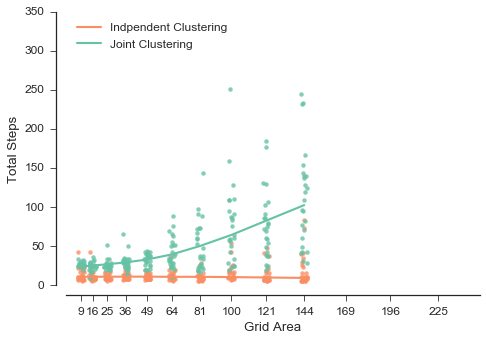

In [5]:
X0 = results[results['In Goal']].groupby(['Grid Area', 'Model', 'Iteration',]).sum()
X1 = []
for ga in set(results['Grid Area']):
    X1.append(pd.DataFrame({
        'Cumulative Steps Taken': np.concatenate([
                X0.loc[ga, 'Independent', :]['Step'].values,
                X0.loc[ga, 'Joint', :]['Step'].values,
                X0.loc[ga, 'Flat', :]['Step'].values, 
            ]),
        'Model': ['Independent'] * n_sims + ['Joint'] * n_sims + ['Flat'] * n_sims,
        'Grid Area': [ga] * n_sims * 3
    }))
X1 = pd.concat(X1)
sns.set_context('paper', font_scale=1.5)

with sns.axes_style('ticks'):

    fig, ax = plt.subplots(figsize=(7, 5))
    cc = sns.color_palette('Set2')
    sns.regplot(x='Grid Area', y='Cumulative Steps Taken',lowess=True,
                data=X1[X1['Model'] == 'Independent'], ax=ax, color=cc[1],
                x_jitter=2,  line_kws={'label':'Indpendent Clustering'},
#                 x_estimator=np.mean,
               )
    
    sns.regplot(x='Grid Area', y='Cumulative Steps Taken',lowess=True,
                data=X1[X1['Model'] == 'Joint'],
                x_jitter=2,
#                 x_estimator=np.median, 
                color=cc[0], line_kws={'label':'Joint Clustering'})
    
#     sns.regplot(x='Grid Area', y='Cumulative Steps Taken',lowess=True,
#                 data=X1[X1['Model'] == 'Flat'],
#                 x_jitter=2,
#                 #x_estimator=np.median, 
#                 color=cc[2], line_kws={'label':'Flat'})
    
#     ax.set_yscale('log')
    ax.set_ylim([0, 350])
    ax.set_ylabel('Total Steps')
    ax.set_xticks([ii**2 for ii in range(3, 16)])
    ax.set_xlim([0, 250])
    sns.despine(offset=10, trim=False)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('Growth_area.png', dpi=300)

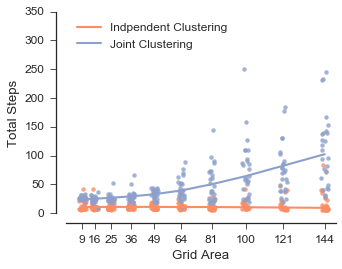

In [17]:
X0 = results[results['In Goal']].groupby(['Grid Area', 'Model', 'Iteration',]).sum()
X1 = []
for ga in set(results['Grid Area']):
    X1.append(pd.DataFrame({
        'Cumulative Steps Taken': np.concatenate([
                X0.loc[ga, 'Independent', :]['Step'].values,
                X0.loc[ga, 'Joint', :]['Step'].values,
                X0.loc[ga, 'Flat', :]['Step'].values, 
            ]),
        'Model': ['Independent'] * n_sims + ['Joint'] * n_sims + ['Flat'] * n_sims,
        'Grid Area': [ga] * n_sims * 3
    }))
X1 = pd.concat(X1)
with sns.axes_style('ticks'):

    fig, ax = plt.subplots(figsize=(5, 4))
    cc = sns.color_palette('Set2')
    sns.regplot(x='Grid Area', y='Cumulative Steps Taken',lowess=True,
                data=X1[X1['Model'] == 'Independent'], ax=ax, color=cc[1],
                x_jitter=2,  line_kws={'label':'Indpendent Clustering'},
#                 x_estimator=np.mean,
               )
    
    sns.regplot(x='Grid Area', y='Cumulative Steps Taken',lowess=True,
                data=X1[X1['Model'] == 'Joint'],
                x_jitter=2,
#                 x_estimator=np.median, 
                color=cc[2], line_kws={'label':'Joint Clustering'})
    
#     sns.regplot(x='Grid Area', y='Cumulative Steps Taken',lowess=True,
#                 data=X1[X1['Model'] == 'Flat'],
#                 x_jitter=2,
#                 #x_estimator=np.median, 
#                 color=cc[2], line_kws={'label':'Flat'})
    
#     ax.set_yscale('log')
    ax.set_ylim([0, 350])
    ax.set_ylabel('Total Steps')
    ax.set_xticks([ii**2 for ii in range(3, 16)])
    ax.set_xlim([0, 150])
    sns.despine(offset=10, trim=False)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('Growth_area2.png', dpi=300)

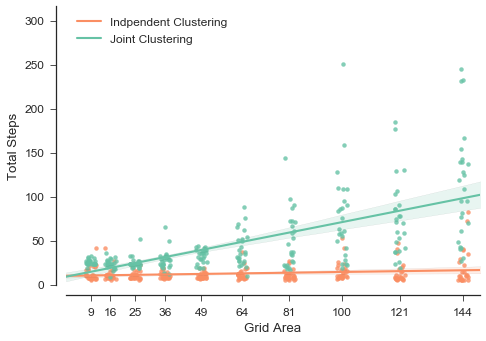

In [7]:
X0 = results[results['In Goal']].groupby(['Grid Area', 'Model', 'Iteration',]).sum()
X1 = []
for ga in set(results['Grid Area']):
    X1.append(pd.DataFrame({
        'Cumulative Steps Taken': np.concatenate([
                X0.loc[ga, 'Independent', :]['Step'].values,
                X0.loc[ga, 'Joint', :]['Step'].values,
                X0.loc[ga, 'Flat', :]['Step'].values, 
            ]),
        'Model': ['Independent'] * n_sims + ['Joint'] * n_sims + ['Flat'] * n_sims,
        'Grid Area': [ga] * n_sims * 3
    }))
X1 = pd.concat(X1)

with sns.axes_style('ticks'):

    fig, ax = plt.subplots(figsize=(7, 5))
    cc = sns.color_palette('Set2')
    sns.regplot(x='Grid Area', y='Cumulative Steps Taken', #lowess=True,
#                 logx=True,
                data=X1[X1['Model'] == 'Independent'], ax=ax, color=cc[1],
                x_jitter=2,  line_kws={'label':'Indpendent Clustering'},
#                 x_estimator=np.mean,
               )
    
    sns.regplot(x='Grid Area', y='Cumulative Steps Taken',#lowess=True,
                data=X1[X1['Model'] == 'Joint'],
#                 logx=True,
                x_jitter=2,
#                 x_estimator=np.median, 
                color=cc[0], line_kws={'label':'Joint Clustering'})
    
#     sns.regplot(x='Grid Area', y='Cumulative Steps Taken',lowess=True,
#                 data=X1[X1['Model'] == 'Flat'],
#                 x_jitter=2,
#                 #x_estimator=np.median, 
#                 color=cc[2], line_kws={'label':'Flat'})
    
#     ax.set_yscale('log')
    ax.set_ylim([0, 10**2.5])
    ax.set_ylabel('Total Steps')
    ax.set_xticks([ii**2 for ii in range(3, 16)])
    ax.set_xlim([0, 150])
    sns.despine(offset=10, trim=False)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('Growth_area3.png', dpi=300)

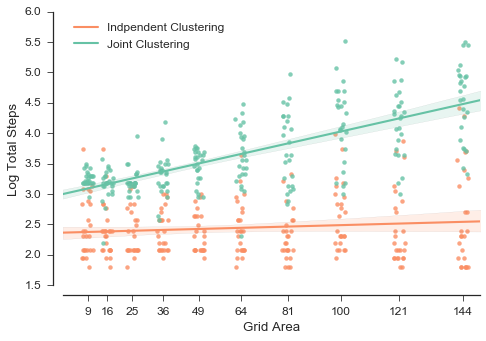

In [8]:
X0 = results[results['In Goal']].groupby(['Grid Area', 'Model', 'Iteration',]).sum()
X1 = []
for ga in set(results['Grid Area']):
    X1.append(pd.DataFrame({
        'Cumulative Steps Taken': np.concatenate([
                np.log(X0.loc[ga, 'Independent', :]['Step'].values),
                np.log(X0.loc[ga, 'Joint', :]['Step'].values),
                np.log(X0.loc[ga, 'Flat', :]['Step'].values), 
            ]),
        'Model': ['Independent'] * n_sims + ['Joint'] * n_sims + ['Flat'] * n_sims,
        'Grid Area': [ga] * n_sims * 3
    }))
X1 = pd.concat(X1)

with sns.axes_style('ticks'):

    fig, ax = plt.subplots(figsize=(7, 5))
    cc = sns.color_palette('Set2')
    sns.regplot(x='Grid Area', y='Cumulative Steps Taken',#robust=True,
                data=X1[X1['Model'] == 'Independent'], ax=ax, color=cc[1],
                x_jitter=2,  line_kws={'label':'Indpendent Clustering'},
#                 x_estimator=np.median,
               )
    
    sns.regplot(x='Grid Area', y='Cumulative Steps Taken',#robust=True,
                data=X1[X1['Model'] == 'Joint'],
                x_jitter=2,
#                 x_estimator=np.median, 
                color=cc[0], line_kws={'label':'Joint Clustering'})
    
#     sns.regplot(x='Grid Area', y='Cumulative Steps Taken',#lowess=True,
#                 data=X1[X1['Model'] == 'Flat'],
#                 x_jitter=2,
#                 #x_estimator=np.median, 
#                 color=cc[2], line_kws={'label':'Flat'})
    
#     ax.set_yscale('log')
#     ax.set_ylim([10**1.5, 10**5])
    ax.set_xticks([ii**2 for ii in range(3, 16)])
    ax.set_xlim([0, 150])
    ax.set_ylabel('Log Total Steps')
    sns.despine(offset=10, trim=False)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('Growth_area_log.png', dpi=300)

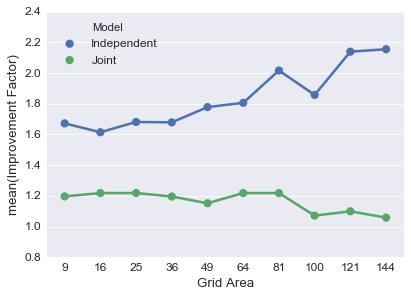

In [9]:
X2 = X1.groupby(['Model', 'Grid Area']).median().reset_index()
for ga in set(X2['Grid Area']):
    X2.loc[X2['Grid Area'] == ga, 'Cumulative Steps Taken'] /= \
        X2.loc[X2['Grid Area'] == ga, 'Cumulative Steps Taken'].max()
X2['Improvement Factor'] = 1/X2['Cumulative Steps Taken']
sns.pointplot(data=X2[X2['Model'] !='Flat'], x='Grid Area', y='Improvement Factor', hue='Model')

In [10]:
results2 = []
for n_rep in range(1, 13):
    rooms_args, rooms_kwargs = make_rooms(grid_world_size=(5, 5), n_repeats = n_rep)
    _res = sim_task(rooms_args, rooms_kwargs)
    _res['N Reps'] = [n_rep] * len(_res)
    results2.append(_res)
results2 = pd.concat(results2)

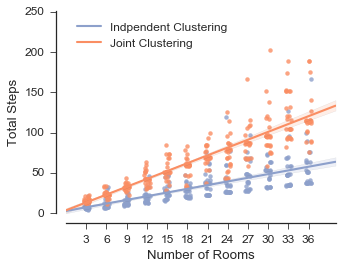

In [24]:
X0 = results2[results2['In Goal']].groupby(['N Reps', 'Model', 'Iteration',]).sum()
X1 = []
for n in set(results2['N Reps']):
    X1.append(pd.DataFrame({
        'Cumulative Steps Taken': np.concatenate([
                X0.loc[n, 'Independent', :]['Step'].values,
                X0.loc[n, 'Joint', :]['Step'].values,
                X0.loc[n, 'Flat', :]['Step'].values, 
            ]),
        'Model': ['Independent'] * n_sims + ['Joint'] * n_sims + ['Flat'] * n_sims,
        'Number of Rooms': [n*3] * n_sims * 3
    }))
X1 = pd.concat(X1)
# sns.factorplot(x='N Reps', y='Cumulative Steps Taken',
#                hue='Model', data=X1[X1['Model'] != 'Flat'])

with sns.axes_style('ticks'):

    fig, ax = plt.subplots(figsize=(5, 4))
    cc = sns.color_palette('Set2')
    sns.regplot(x='Number of Rooms', y='Cumulative Steps Taken',#lowess=True,
                data=X1[X1['Model'] == 'Independent'], ax=ax, color=cc[2],
                x_jitter=0.4,  line_kws={'label':'Indpendent Clustering'},
#                 x_estimator=np.mean,
               )
    
    sns.regplot(x='Number of Rooms', y='Cumulative Steps Taken',#lowess=True,
                data=X1[X1['Model'] == 'Joint'],
                x_jitter=0.4,
#                 x_estimator=np.median, 
                color=cc[1], line_kws={'label':'Joint Clustering'})
    
#     sns.regplot(x='Number of Rooms', y='Cumulative Steps Taken',#lowess=True,
#                 data=X1[X1['Model'] == 'Flat'],
#                 x_jitter=2,
#                 #x_estimator=np.median, 
#                 color=cc[2], line_kws={'label':'Flat'})
    
#     ax.set_yscale('log')
    ax.set_ylim([0, 251])
    ax.set_ylabel('Total Steps')
    ax.set_xticks(range(3, 39, 3))
#     ax.set_xlim([0, 10])
    sns.despine(offset=10, trim=False)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('Growth_rooms.png', dpi=300)

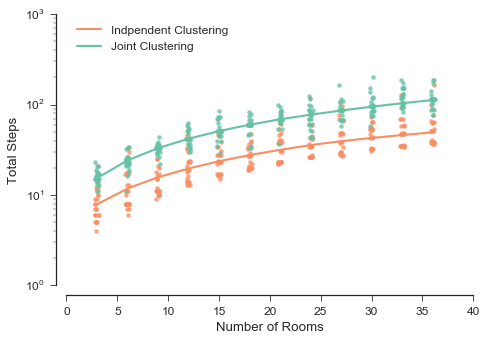

In [12]:
X0 = results2[results2['In Goal']].groupby(['N Reps', 'Model', 'Iteration',]).sum()
X1 = []
for n in set(results2['N Reps']):
    X1.append(pd.DataFrame({
        'Cumulative Steps Taken': np.concatenate([
                X0.loc[n, 'Independent', :]['Step'].values,
                X0.loc[n, 'Joint', :]['Step'].values,
                X0.loc[n, 'Flat', :]['Step'].values, 
            ]),
        'Model': ['Independent'] * n_sims + ['Joint'] * n_sims + ['Flat'] * n_sims,
        'Number of Rooms': [n*3] * n_sims * 3
    }))
X1 = pd.concat(X1)
# sns.factorplot(x='N Reps', y='Cumulative Steps Taken',
#                hue='Model', data=X1[X1['Model'] != 'Flat'])

with sns.axes_style('ticks'):

    fig, ax = plt.subplots(figsize=(7, 5))
    cc = sns.color_palette('Set2')
    sns.regplot(x='Number of Rooms', y='Cumulative Steps Taken',lowess=True,
                data=X1[X1['Model'] == 'Independent'], ax=ax, color=cc[1],
                x_jitter=0.2,  line_kws={'label':'Indpendent Clustering'},
#                 x_estimator=np.mean,
               )
    
    sns.regplot(x='Number of Rooms', y='Cumulative Steps Taken',lowess=True,
                data=X1[X1['Model'] == 'Joint'],
                x_jitter=0.2,
#                 x_estimator=np.median, 
                color=cc[0], line_kws={'label':'Joint Clustering'})
    
#     sns.regplot(x='Number of Rooms', y='Cumulative Steps Taken',#lowess=True,
#                 data=X1[X1['Model'] == 'Flat'],
#                 x_jitter=2,
#                 #x_estimator=np.median, 
#                 color=cc[2], line_kws={'label':'Flat'})
    
    ax.set_yscale('log')
#     ax.set_ylim([0, 251])
#     ax.set_xticks([ii**2 for ii in range(3, 13)])
#     ax.set_xlim([0, 10])
    ax.set_ylabel('Total Steps')

    sns.despine(offset=10, trim=False)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('Growth_rooms2.png', dpi=300)